In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [4]:
train_df = pd.read_csv('reco_assignment_training.csv')
test_df = pd.read_csv('reco_assignment_holdout.csv')

In [116]:
train_df.head()

Customer_num     Tran_dt Product_num  Tran_qty
0     C_203152  2022-01-02      P_3365     0.135
1    C_1607154  2022-01-02        P_58     1.000
2      C_84518  2022-01-02     P_21295     1.000
3    C_2553711  2022-01-02     P_20576     1.000
4    C_2376922  2022-01-02      P_1095     2.000

In [117]:
train_df.Customer_num.nunique(),test_df.Customer_num.nunique()


(9835, 9835)

In [118]:
# train_df['Customer_num'] = train_df['Customer_num'].str.split('_').str[1]
# train_df['Product_num'] = train_df['Product_num'].str.split('_').str[1]
# train_df.head()

In [119]:
# test_df['Customer_num'] = test_df['Customer_num'].str.split('_').str[1]
# test_df['Product_num'] = test_df['Product_num'].str.split('_').str[1]
# test_df.head()

In [120]:
# train_df['Customer_num'] = train_df['Customer_num'].astype(int)
# train_df['Product_num'] = train_df['Product_num'].astype(int)
# test_df['Customer_num'] = test_df['Customer_num'].astype(int)
# test_df['Product_num'] = test_df['Product_num'].astype(int)

In [121]:
train_df.Customer_num.max(),train_df.Product_num.max(),train_df.Customer_num.min(),train_df.Product_num.min()

('C_999487', 'P_9992', 'C_100082', 'P_10')

In [122]:
test_df.Customer_num.max(),test_df.Product_num.max(),test_df.Customer_num.min(),test_df.Product_num.min()

('C_999487', 'P_9992', 'C_100082', 'P_10')

In [123]:
train_df['Customer_num'] = pd.Categorical(train_df['Customer_num'])
user_categories = train_df['Customer_num'].cat.categories
test_df['Customer_num'] = pd.Categorical(test_df['Customer_num'], user_categories)

train_df['Product_num'] = pd.Categorical(train_df['Product_num'])
product_categories = train_df['Product_num'].cat.categories
test_df['Product_num'] = pd.Categorical(test_df['Product_num'], product_categories)

train_df['user_id'] = train_df['Customer_num'].cat.codes
test_df['user_id'] = test_df['Customer_num'].cat.codes
train_df['product_id'] = train_df['Product_num'].cat.codes
test_df['product_id'] = test_df['Product_num'].cat.codes

In [156]:
train_df.head()

Customer_num     Tran_dt Product_num  Tran_qty  user_id  product_id
0     C_203152  2022-01-02      P_3365     0.135     4329       10136
1    C_1607154  2022-01-02        P_58     1.000     2558       14988
2      C_84518  2022-01-02     P_21295     1.000     9224        5571
3    C_2553711  2022-01-02     P_20576     1.000     6530        5194
4    C_2376922  2022-01-02      P_1095     2.000     5802         493

## ALS model to predict the next 3 products recommendation

In [124]:
interactions = train_df[['user_id','product_id','Tran_qty']]
interactions  = train_df.groupby(['user_id','product_id'])['Tran_qty'].count().reset_index()
interactions.head()

user_id  product_id  Tran_qty
0        0          48         1
1        0        1338         1
2        0        1340         1
3        0        1486         1
4        0        1850         1

In [125]:
# grouped_df = train_df.groupby(['Customer_num','Product_num'])['Tran_qty'].count().reset_index()
# grouped_df.head()

In [126]:
print(f'Number of unique customers: {interactions.user_id.nunique()}')
print(f'Number of unique items: {interactions.product_id.nunique()}')

print(f'Average purchase quantity per interaction: {int(interactions.Tran_qty.mean())}')
print(f'Minimum purchase quantity per interaction: {interactions.Tran_qty.min()}')
print(f'Maximum purchase quantity per interaction: {interactions.Tran_qty.max()}')

Number of unique customers: 9835
Number of unique items: 17411
Average purchase quantity per interaction: 1
Minimum purchase quantity per interaction: 1
Maximum purchase quantity per interaction: 70


In [127]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
sparse_item_customer = sparse.csr_matrix((interactions['Tran_qty'].astype(float), (interactions['product_id'], interactions['user_id'])))
sparse_customer_item = sparse.csr_matrix((interactions['Tran_qty'].astype(float), (interactions['user_id'], interactions['product_id'])))

In [128]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.2, iterations=100)
alpha = 15
data = (sparse_item_customer * alpha).astype('double')
model.fit(data)

100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


In [129]:
user_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

In [130]:
user_id_mapping = dict(zip(train_df.Customer_num,train_df.user_id))
user_id_mapping_rev = dict(zip(train_df.user_id,train_df.Customer_num))
item_id_mapping = dict(zip(train_df.Product_num,train_df.product_id))
item_id_mapping_rev = dict(zip(train_df.product_id,train_df.Product_num))

In [131]:
def recommend(user_id, sparse_user_item, user_vecs, item_vecs, item_id_mapping_rev,num_items=5):
    user_interactions = sparse_user_item[user_id,:].toarray()
    user_interactions = user_interactions.reshape(-1) + 1
    user_interactions[user_interactions > 1] = 0
    rec_vector = item_vecs[user_id,:].dot(user_vecs.T).toarray()
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
    reco = []
    scores = []
    titles = []
    # print(item_idx)
    for idx in item_idx:
        reco.append(item_id_mapping_rev[idx])
        scores.append(recommend_vector[idx])
        
        
    # return recommendations
    return reco,scores

In [133]:
recommend(0, sparse_customer_item, user_vecs, item_vecs, item_id_mapping_rev,num_items=3)

(['P_7819', 'P_7983', 'P_12777'],
 [1.0, 0.9786791205406189, 0.9677091240882874])

In [134]:
user_id_mapping_rev[120]

'C_1025751'

In [135]:
test_df[test_df.Customer_num=='C_1025751']

Customer_num     Tran_dt Product_num  Tran_qty  user_id  product_id
1406      C_1025751  2022-04-04     P_16135       1.0      120        3074
141317    C_1025751  2022-04-04      P_3382       1.0      120       10281
176314    C_1025751  2022-04-04     P_15762       1.0      120        2883
176323    C_1025751  2022-04-04      P_3475       1.0      120       10724
176519    C_1025751  2022-04-05      P_2714       1.0      120        7417
211549    C_1025751  2022-04-05     P_16717       1.0      120        3350
264505    C_1025751  2022-04-05     P_12834       1.0      120        1430
334939    C_1025751  2022-04-04     P_10088       1.0      120          48
334980    C_1025751  2022-04-04      P_3688       1.0      120       11609

## Five similar users calculation

In [5]:
interactions1  = train_df.groupby(['Customer_num','Product_num'])['Tran_qty'].count().reset_index()


In [6]:
pivot_data =  pd.pivot_table(interactions1,values='Tran_qty',index='Customer_num',columns='Product_num')
pivot_data.head()

Product_num   P_10  P_1000  P_10002  P_10007  P_10008  P_10009  P_1001  \
Customer_num                                                             
C_100082       NaN     NaN      NaN      NaN      NaN      NaN     NaN   
C_1001004      NaN     NaN      NaN      NaN      NaN      NaN     NaN   
C_1001197      NaN     NaN      NaN      NaN      NaN      NaN     NaN   
C_1001322      NaN     NaN      NaN      NaN      NaN      NaN     NaN   
C_1001329      NaN     NaN      NaN      NaN      NaN      NaN     NaN   

Product_num   P_10010  P_10011  P_10012  ...  P_9978  P_9979  P_998  P_9980  \
Customer_num                             ...                                  
C_100082          NaN      NaN      NaN  ...     NaN     NaN    NaN     NaN   
C_1001004         NaN      NaN      NaN  ...     NaN     NaN    NaN     NaN   
C_1001197         NaN      NaN      NaN  ...     NaN     NaN    NaN     NaN   
C_1001322         NaN      NaN      NaN  ...     NaN     NaN    NaN     NaN   
C_1001329         NaN      NaN      NaN  ...     NaN     NaN    NaN     NaN   

Product_num   P_9983  P_9984  P_9988  P_999  P_9991  P_9992  
Customer_num                                                 
C_100082         NaN     NaN     NaN    NaN     NaN     NaN  
C_1001004        NaN     NaN     NaN    NaN     NaN     NaN  
C_1001197        NaN     NaN     NaN    NaN     NaN     NaN  
C_1001322        NaN     NaN     NaN    NaN     NaN     NaN  
C_1001329        NaN     NaN     NaN    NaN     NaN     NaN  

[5 rows x 17411 columns]

In [7]:
pivot_data = pivot_data.apply(lambda row: row.fillna(row.mean()), axis=1)
pivot_data.head()

Product_num       P_10    P_1000   P_10002   P_10007   P_10008   P_10009  \
Customer_num                                                               
C_100082      1.166667  1.166667  1.166667  1.166667  1.166667  1.166667   
C_1001004     1.266667  1.266667  1.266667  1.266667  1.266667  1.266667   
C_1001197     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
C_1001322     1.928571  1.928571  1.928571  1.928571  1.928571  1.928571   
C_1001329     2.139241  2.139241  2.139241  2.139241  2.139241  2.139241   

Product_num     P_1001   P_10010   P_10011   P_10012  ...    P_9978    P_9979  \
Customer_num                                          ...                       
C_100082      1.166667  1.166667  1.166667  1.166667  ...  1.166667  1.166667   
C_1001004     1.266667  1.266667  1.266667  1.266667  ...  1.266667  1.266667   
C_1001197     1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
C_1001322     1.928571  1.928571  1.928571  1.928571  ...  1.928571  1.928571   
C_1001329     2.139241  2.139241  2.139241  2.139241  ...  2.139241  2.139241   

Product_num      P_998    P_9980    P_9983    P_9984    P_9988     P_999  \
Customer_num                                                               
C_100082      1.166667  1.166667  1.166667  1.166667  1.166667  1.166667   
C_1001004     1.266667  1.266667  1.266667  1.266667  1.266667  1.266667   
C_1001197     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
C_1001322     1.928571  1.928571  1.928571  1.928571  1.928571  1.928571   
C_1001329     2.139241  2.139241  2.139241  2.139241  2.139241  2.139241   

Product_num     P_9991    P_9992  
Customer_num                      
C_100082      1.166667  1.166667  
C_1001004     1.266667  1.266667  
C_1001197     1.000000  1.000000  
C_1001322     1.928571  1.928571  
C_1001329     2.139241  2.139241  

[5 rows x 17411 columns]

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
b = cosine_similarity(pivot_data)
np.fill_diagonal(b, 0 )
similarity_with_user = pd.DataFrame(b,index=pivot_data.index)
similarity_with_user.columns=pivot_data.index
similarity_with_user.head()

Customer_num  C_100082  C_1001004  C_1001197  C_1001322  C_1001329  C_1001363  \
Customer_num                                                                    
C_100082      0.000000   0.999766   0.999905   0.999034   0.994214   0.999837   
C_1001004     0.999766   0.000000   0.999859   0.998973   0.994154   0.999786   
C_1001197     0.999905   0.999859   0.000000   0.999129   0.994304   0.999932   
C_1001322     0.999034   0.998973   0.999129   0.000000   0.993438   0.999061   
C_1001329     0.994214   0.994154   0.994304   0.993438   0.000000   0.994237   

Customer_num  C_1001411  C_1001612  C_100187  C_1002010  ...  C_998085  \
Customer_num                                             ...             
C_100082       0.995541   0.998609  0.999372   0.999384  ...  0.999869   
C_1001004      0.995476   0.998568  0.999290   0.999341  ...  0.999823   
C_1001197      0.995632   0.998704  0.999467   0.999479  ...  0.999963   
C_1001322      0.994776   0.997834  0.998597   0.998609  ...  0.999093   
C_1001329      0.989973   0.993010  0.993774   0.993768  ...  0.994272   

Customer_num  C_998307  C_998572  C_998684  C_998829  C_998908  C_999117  \
Customer_num                                                               
C_100082      0.999622  0.999878  0.999880  0.999660  0.999663  0.999418   
C_1001004     0.999582  0.999832  0.999834  0.999616  0.999617  0.999369   
C_1001197     0.999717  0.999972  0.999975  0.999755  0.999758  0.999513   
C_1001322     0.998846  0.999102  0.999104  0.998885  0.998887  0.998643   
C_1001329     0.994024  0.994277  0.994280  0.994061  0.994063  0.993822   

Customer_num  C_999155  C_999171  C_999487  
Customer_num                                
C_100082      0.999771  0.999760  0.997554  
C_1001004     0.999725  0.999717  0.997534  
C_1001197     0.999866  0.999855  0.997648  
C_1001322     0.998995  0.998984  0.996780  
C_1001329     0.994171  0.994160  0.991935  

[5 rows x 9835 columns]

In [9]:
def five_sim_users(df,n=5):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [10]:
sim_u = five_sim_users(similarity_with_user,5)
sim_u.head()

top1       top2       top3       top4       top5
Customer_num                                                       
C_100082        C_26583  C_1613646  C_1614082  C_2370709  C_2369788
C_1001004      C_720010  C_1606751   C_582800   C_906397  C_2526515
C_1001197     C_1553254   C_476603  C_1968881  C_1474354  C_1968688
C_1001322       C_48999  C_1166002  C_2491607   C_977277  C_2245248
C_1001329       C_19691   C_298064   C_884581   C_780107  C_2364181

In [11]:
sim_u.to_csv('similar_users.csv',index=False)

## Inbuilt method from Implicit Library

In [150]:
item_id = 1
n_similar = 5
similar = model.similar_items(item_id, n_similar)
print(similar)

(array([   1,  834, 4612,  727, 2007]), array([1.0000001 , 0.764539  , 0.74277204, 0.73358977, 0.72031915],
      dtype=float32))


In [ ]:
def similar_users( userid, N=5, filter_users=None, users=None):
        user_factors = self.user_factors
        norms = self.user_norms
        norm = norms[userid]

        # if we have an user list to restrict down to, we need to filter the user_factors
        if users is not None:
            if filter_users:
                raise ValueError("Can't set both users and filter_users in similar_users call")

            users = np.array(users)
            user_factors = user_factors[users]
            norms = norms[users]

            # check selected items are in the model
            if users.max() >= self.user_factors.shape[0] or users.min() < 0:
                raise IndexError("Some userids in the users parameter are not in the model")

        factor = self.user_factors[userid]
        ids, scores = self._get_similarity_score(
            factor, norm, user_factors, norms, N, filter_items=filter_users
        )
        if users is not None:
            ids = users[ids]

        return ids, scores

In [54]:
# calculate the recommendations for each user in the test set
from tqdm import tqdm
test_recommendations = []
for user_id in tqdm(test_df.user_id.unique()):
    reco,scores = recommend(user_id, sparse_customer_item, user_vecs, item_vecs,item_id_mapping_rev)
    test_recommendations.append(reco)

100%|██████████| 9835/9835 [00:48<00:00, 200.74it/s]


## Recall Calculation @ 3

In [55]:
def recall_at_k(recommendations, test_set, k=5):
    hits = 0
    for user_id, user_recos in tqdm(enumerate(recommendations)):
        if user_id in test_set.user_id.unique():
            # print('*'*10)
            # print(user_recos[:k])
            temp = []
            for item in user_recos[:k]:
                temp.append(item_id_mapping[item])
            # print(temp)
            hits += len(set(temp).intersection(test_set[test_set.user_id==user_id].product_id.unique()))
            # print(test_set[test_set.user_id==user_id].product_id.unique())
            # print(hits)
            # print('*'*10)
    return hits / len(test_set)

In [56]:
# evaluate the recommendations using recall@k
recall_at_k(test_recommendations, test_df, k=3)

9835it [00:28, 339.90it/s]


0.0038133507115883174

In [58]:
# five similar users for each user in the train set
similar_users = []
for user_id in tqdm(train_df.user_id.unique()):
    similar_users.append(user_vecs[user_id,:].dot(user_vecs.T).toarray())
similar_users = np.array(similar_users)
similar_users = np.argsort(similar_users, axis=1)[:,::-1][:,:5]
# similar_users = pd.DataFrame(similar_users, columns=['user_id_1','user_id_2','user_id_3','user_id_4','user_id_5'])
# similar_users.head()


100%|██████████| 9835/9835 [00:35<00:00, 273.66it/s]


In [75]:
# hyperparameter tuning for alpha, regularization, iterations and factors and select the best model on recall@k where k=3
from tqdm import tqdm
# factors = [10, 20, 30]
alpha = [5,10,15,20,25,30]
regularization = [0.1,0.2,0.3,0.4,0.5]
iterations = [10,20,30,40,50]
for a in alpha:
    for r in regularization:
        for i in iterations:
            # for f in factors:
            model = implicit.als.AlternatingLeastSquares(factors=20, regularization=r, iterations=i)
            data = (sparse_item_customer * a).astype('double')
            model.fit(data)
            user_vecs = sparse.csr_matrix(model.user_factors)
            item_vecs = sparse.csr_matrix(model.item_factors)
            test_recommendations = []
            for user_id in tqdm(test_df.user_id.unique()):
                reco,scores = recommend(user_id, sparse_customer_item, user_vecs, item_vecs,item_id_mapping_rev)
                test_recommendations.append(reco)
            print(f'Alpha: {a}, Regularization: {r}, Iterations: {i}')
            print(f'Recall@k: {recall_at_k(test_recommendations, test_df, k=3)**0.5}')
            print('\n')

100%|██████████| 9835/9835 [00:47<00:00, 205.87it/s]


Alpha: 5, Regularization: 0.1, Iterations: 10


9835it [00:28, 349.94it/s]


Recall@k: 0.066863494088481




100%|██████████| 9835/9835 [00:47<00:00, 206.50it/s]


Alpha: 5, Regularization: 0.1, Iterations: 20


9835it [00:28, 344.99it/s]


Recall@k: 0.06777238049961604




100%|██████████| 9835/9835 [00:47<00:00, 208.84it/s]


Alpha: 5, Regularization: 0.1, Iterations: 30


9835it [00:27, 351.79it/s]


Recall@k: 0.06764629224063932




100%|██████████| 9835/9835 [00:48<00:00, 202.87it/s]


Alpha: 5, Regularization: 0.1, Iterations: 40


9835it [00:29, 336.89it/s]


Recall@k: 0.0666930323858147




100%|██████████| 9835/9835 [00:47<00:00, 207.81it/s]


Alpha: 5, Regularization: 0.1, Iterations: 50


9835it [00:27, 353.48it/s]


Recall@k: 0.06639367131912174




100%|██████████| 9835/9835 [00:48<00:00, 203.00it/s]


Alpha: 5, Regularization: 0.2, Iterations: 10


9835it [00:28, 339.42it/s]


Recall@k: 0.06758315989628337




100%|██████████| 9835/9835 [00:49<00:00, 197.10it/s]


Alpha: 5, Regularization: 0.2, Iterations: 20


9835it [00:28, 348.13it/s]


Recall@k: 0.06639367131912174




100%|██████████| 9835/9835 [00:48<00:00, 202.95it/s]


Alpha: 5, Regularization: 0.2, Iterations: 30


9835it [00:28, 344.02it/s]


Recall@k: 0.06718194402826713




100%|██████████| 9835/9835 [00:48<00:00, 204.38it/s]


Alpha: 5, Regularization: 0.2, Iterations: 40


9835it [00:28, 343.07it/s]


Recall@k: 0.06690604165504477




100%|██████████| 9835/9835 [00:47<00:00, 209.20it/s]


Alpha: 5, Regularization: 0.2, Iterations: 50


9835it [00:29, 335.24it/s]


Recall@k: 0.0669485621815199




100%|██████████| 9835/9835 [00:47<00:00, 207.60it/s]


Alpha: 5, Regularization: 0.3, Iterations: 10


9835it [00:28, 340.05it/s]


Recall@k: 0.06934965862340117




100%|██████████| 9835/9835 [00:49<00:00, 198.98it/s]


Alpha: 5, Regularization: 0.3, Iterations: 20


9835it [00:29, 338.66it/s]


Recall@k: 0.06707596203448438




100%|██████████| 9835/9835 [00:47<00:00, 205.60it/s]


Alpha: 5, Regularization: 0.3, Iterations: 30


9835it [00:28, 340.26it/s]


Recall@k: 0.06796107426757515




100%|██████████| 9835/9835 [00:50<00:00, 196.14it/s]


Alpha: 5, Regularization: 0.3, Iterations: 40


9835it [00:28, 340.42it/s]


Recall@k: 0.06688477125499839




100%|██████████| 9835/9835 [00:49<00:00, 199.73it/s]


Alpha: 5, Regularization: 0.3, Iterations: 50


9835it [00:28, 345.27it/s]


Recall@k: 0.0663507951949735




100%|██████████| 9835/9835 [00:49<00:00, 197.47it/s]


Alpha: 5, Regularization: 0.4, Iterations: 10


9835it [00:31, 309.70it/s]


Recall@k: 0.06819099090677043




100%|██████████| 9835/9835 [00:50<00:00, 194.42it/s]


Alpha: 5, Regularization: 0.4, Iterations: 20


9835it [00:28, 345.54it/s]


Recall@k: 0.06658627222070403




100%|██████████| 9835/9835 [00:46<00:00, 212.06it/s]


Alpha: 5, Regularization: 0.4, Iterations: 30


9835it [00:27, 359.65it/s]


Recall@k: 0.06690604165504477




100%|██████████| 9835/9835 [00:46<00:00, 210.91it/s]


Alpha: 5, Regularization: 0.4, Iterations: 40


9835it [00:27, 360.16it/s]


Recall@k: 0.0669698123208208




100%|██████████| 9835/9835 [00:46<00:00, 213.01it/s]


Alpha: 5, Regularization: 0.4, Iterations: 50


9835it [00:27, 356.34it/s]


Recall@k: 0.06639367131912174




100%|██████████| 9835/9835 [00:49<00:00, 197.75it/s]


Alpha: 5, Regularization: 0.5, Iterations: 10


9835it [00:27, 358.07it/s]


Recall@k: 0.06741451793687765




100%|██████████| 9835/9835 [00:46<00:00, 212.85it/s]


Alpha: 5, Regularization: 0.5, Iterations: 20


9835it [00:27, 359.79it/s]


Recall@k: 0.0669485621815199




100%|██████████| 9835/9835 [00:46<00:00, 211.64it/s]


Alpha: 5, Regularization: 0.5, Iterations: 30


9835it [00:27, 361.16it/s]


Recall@k: 0.06690604165504477




100%|██████████| 9835/9835 [00:46<00:00, 212.73it/s]


Alpha: 5, Regularization: 0.5, Iterations: 40


9835it [00:27, 359.62it/s]


Recall@k: 0.06639367131912174




100%|██████████| 9835/9835 [00:46<00:00, 210.28it/s]


Alpha: 5, Regularization: 0.5, Iterations: 50


9835it [00:27, 360.57it/s]


Recall@k: 0.06684221014903088




100%|██████████| 9835/9835 [00:46<00:00, 211.99it/s]


Alpha: 10, Regularization: 0.1, Iterations: 10


9835it [00:27, 358.49it/s]


Recall@k: 0.06467845581253967




100%|██████████| 9835/9835 [00:46<00:00, 211.69it/s]


Alpha: 10, Regularization: 0.1, Iterations: 20


9835it [00:27, 359.89it/s]


Recall@k: 0.06392609785094329




100%|██████████| 9835/9835 [00:46<00:00, 211.13it/s]


Alpha: 10, Regularization: 0.1, Iterations: 30


9835it [00:27, 356.22it/s]


Recall@k: 0.06474442059848882




100%|██████████| 9835/9835 [00:46<00:00, 211.61it/s]


Alpha: 10, Regularization: 0.1, Iterations: 40


9835it [00:27, 360.08it/s]


Recall@k: 0.06394835236784058




100%|██████████| 9835/9835 [00:46<00:00, 212.96it/s]


Alpha: 10, Regularization: 0.1, Iterations: 50


9835it [00:27, 359.90it/s]


Recall@k: 0.06439182753132584




100%|██████████| 9835/9835 [00:46<00:00, 211.29it/s]


Alpha: 10, Regularization: 0.2, Iterations: 10


9835it [00:27, 358.76it/s]


Recall@k: 0.0648322692421492




100%|██████████| 9835/9835 [00:45<00:00, 215.76it/s]


Alpha: 10, Regularization: 0.2, Iterations: 20


9835it [00:27, 360.55it/s]


Recall@k: 0.06524793508790844




100%|██████████| 9835/9835 [00:46<00:00, 211.31it/s]


Alpha: 10, Regularization: 0.2, Iterations: 30


9835it [00:27, 359.25it/s]


Recall@k: 0.06428124557177144




100%|██████████| 9835/9835 [00:46<00:00, 212.13it/s]


Alpha: 10, Regularization: 0.2, Iterations: 40


9835it [00:27, 360.77it/s]


Recall@k: 0.064303377177031




100%|██████████| 9835/9835 [00:46<00:00, 211.04it/s]


Alpha: 10, Regularization: 0.2, Iterations: 50


9835it [00:27, 355.10it/s]


Recall@k: 0.06325482165854716




100%|██████████| 9835/9835 [00:46<00:00, 213.38it/s]


Alpha: 10, Regularization: 0.3, Iterations: 10


9835it [00:27, 360.70it/s]


Recall@k: 0.06377009877408453




100%|██████████| 9835/9835 [00:46<00:00, 211.20it/s]


Alpha: 10, Regularization: 0.3, Iterations: 20


9835it [00:27, 359.09it/s]


Recall@k: 0.06425910634412262




100%|██████████| 9835/9835 [00:46<00:00, 213.66it/s]


Alpha: 10, Regularization: 0.3, Iterations: 30


9835it [00:28, 349.99it/s]


Recall@k: 0.06454632399769869




100%|██████████| 9835/9835 [00:46<00:00, 210.31it/s]


Alpha: 10, Regularization: 0.3, Iterations: 40


9835it [00:27, 358.64it/s]


Recall@k: 0.0653568814571315




100%|██████████| 9835/9835 [00:46<00:00, 212.17it/s]


Alpha: 10, Regularization: 0.3, Iterations: 50


9835it [00:27, 360.45it/s]


Recall@k: 0.06459039796937424




100%|██████████| 9835/9835 [00:47<00:00, 208.81it/s]


Alpha: 10, Regularization: 0.4, Iterations: 10


9835it [00:27, 359.34it/s]


Recall@k: 0.06557423118064593




100%|██████████| 9835/9835 [00:46<00:00, 213.59it/s]


Alpha: 10, Regularization: 0.4, Iterations: 20


9835it [00:27, 359.51it/s]


Recall@k: 0.06459039796937424




100%|██████████| 9835/9835 [00:46<00:00, 210.47it/s]


Alpha: 10, Regularization: 0.4, Iterations: 30


9835it [00:27, 356.51it/s]


Recall@k: 0.06363608090523601




100%|██████████| 9835/9835 [00:46<00:00, 213.45it/s]


Alpha: 10, Regularization: 0.4, Iterations: 40


9835it [00:27, 359.72it/s]


Recall@k: 0.06529153545033356




100%|██████████| 9835/9835 [00:46<00:00, 211.54it/s]


Alpha: 10, Regularization: 0.4, Iterations: 50


9835it [00:27, 361.76it/s]


Recall@k: 0.0632323230550759




100%|██████████| 9835/9835 [00:46<00:00, 213.27it/s]


Alpha: 10, Regularization: 0.5, Iterations: 10


9835it [00:27, 360.92it/s]


Recall@k: 0.06377009877408453




100%|██████████| 9835/9835 [00:46<00:00, 211.72it/s]


Alpha: 10, Regularization: 0.5, Iterations: 20


9835it [00:27, 361.74it/s]


Recall@k: 0.0644801565543735




100%|██████████| 9835/9835 [00:46<00:00, 213.64it/s]


Alpha: 10, Regularization: 0.5, Iterations: 30


9835it [00:27, 360.40it/s]


Recall@k: 0.06559592654308591




100%|██████████| 9835/9835 [00:46<00:00, 212.04it/s]


Alpha: 10, Regularization: 0.5, Iterations: 40


9835it [00:27, 360.99it/s]


Recall@k: 0.0638370022008856




100%|██████████| 9835/9835 [00:46<00:00, 212.91it/s]


Alpha: 10, Regularization: 0.5, Iterations: 50


9835it [00:27, 351.32it/s]


Recall@k: 0.06421480499011897




100%|██████████| 9835/9835 [00:46<00:00, 209.83it/s]


Alpha: 15, Regularization: 0.1, Iterations: 10


9835it [00:27, 359.83it/s]


Recall@k: 0.06179840030142017




100%|██████████| 9835/9835 [00:45<00:00, 213.81it/s]


Alpha: 15, Regularization: 0.1, Iterations: 20


9835it [00:27, 356.34it/s]


Recall@k: 0.06202822035933181




100%|██████████| 9835/9835 [00:46<00:00, 211.54it/s]


Alpha: 15, Regularization: 0.1, Iterations: 30


9835it [00:27, 361.17it/s]


Recall@k: 0.06177537127125537




100%|██████████| 9835/9835 [00:46<00:00, 212.48it/s]


Alpha: 15, Regularization: 0.1, Iterations: 40


9835it [00:27, 361.37it/s]


Recall@k: 0.06175233365297474




100%|██████████| 9835/9835 [00:46<00:00, 211.46it/s]


Alpha: 15, Regularization: 0.1, Iterations: 50


9835it [00:27, 359.72it/s]


Recall@k: 0.06195936384927179




100%|██████████| 9835/9835 [00:46<00:00, 212.81it/s]


Alpha: 15, Regularization: 0.2, Iterations: 10


9835it [00:27, 360.62it/s]


Recall@k: 0.061683169173194566




100%|██████████| 9835/9835 [00:46<00:00, 211.34it/s]


Alpha: 15, Regularization: 0.2, Iterations: 20


9835it [00:27, 358.38it/s]


Recall@k: 0.06225719205101593




100%|██████████| 9835/9835 [00:49<00:00, 198.39it/s]


Alpha: 15, Regularization: 0.2, Iterations: 30


9835it [00:31, 316.90it/s]


Recall@k: 0.06225719205101593




100%|██████████| 9835/9835 [00:48<00:00, 202.59it/s]


Alpha: 15, Regularization: 0.2, Iterations: 40


9835it [00:28, 340.54it/s]


Recall@k: 0.06122007576756524




100%|██████████| 9835/9835 [00:48<00:00, 204.43it/s]


Alpha: 15, Regularization: 0.2, Iterations: 50


9835it [00:29, 338.95it/s]


Recall@k: 0.06211991031383036




100%|██████████| 9835/9835 [00:48<00:00, 200.72it/s]


Alpha: 15, Regularization: 0.3, Iterations: 10


9835it [00:29, 337.27it/s]


Recall@k: 0.06239417173707681




100%|██████████| 9835/9835 [00:48<00:00, 203.37it/s]


Alpha: 15, Regularization: 0.3, Iterations: 20


9835it [00:28, 340.48it/s]


Recall@k: 0.06250809217470538




100%|██████████| 9835/9835 [00:48<00:00, 201.60it/s]


Alpha: 15, Regularization: 0.3, Iterations: 30


9835it [00:28, 340.25it/s]


Recall@k: 0.0620052766853975




100%|██████████| 9835/9835 [00:48<00:00, 204.30it/s]


Alpha: 15, Regularization: 0.3, Iterations: 40


9835it [00:28, 339.70it/s]


Recall@k: 0.06172928743696295




100%|██████████| 9835/9835 [00:48<00:00, 202.18it/s]


Alpha: 15, Regularization: 0.3, Iterations: 50


9835it [00:28, 342.86it/s]


Recall@k: 0.06202822035933181




100%|██████████| 9835/9835 [00:48<00:00, 202.58it/s]


Alpha: 15, Regularization: 0.4, Iterations: 10


9835it [00:28, 339.77it/s]


Recall@k: 0.0620052766853975




100%|██████████| 9835/9835 [00:48<00:00, 202.20it/s]


Alpha: 15, Regularization: 0.4, Iterations: 20


9835it [00:29, 338.81it/s]


Recall@k: 0.06195936384927179




100%|██████████| 9835/9835 [00:48<00:00, 204.45it/s]


Alpha: 15, Regularization: 0.4, Iterations: 30


9835it [00:28, 339.19it/s]


Recall@k: 0.06257634488895017




100%|██████████| 9835/9835 [00:48<00:00, 203.35it/s]


Alpha: 15, Regularization: 0.4, Iterations: 40


9835it [00:28, 342.94it/s]


Recall@k: 0.062051155549747425




100%|██████████| 9835/9835 [00:48<00:00, 202.75it/s]


Alpha: 15, Regularization: 0.4, Iterations: 50


9835it [00:28, 340.36it/s]


Recall@k: 0.06075345253336568




100%|██████████| 9835/9835 [00:48<00:00, 202.13it/s]


Alpha: 15, Regularization: 0.5, Iterations: 10


9835it [00:28, 340.45it/s]


Recall@k: 0.06291649784720796




100%|██████████| 9835/9835 [00:48<00:00, 201.38it/s]


Alpha: 15, Regularization: 0.5, Iterations: 20


9835it [00:29, 337.26it/s]


Recall@k: 0.06202822035933181




100%|██████████| 9835/9835 [00:48<00:00, 201.89it/s]


Alpha: 15, Regularization: 0.5, Iterations: 30


9835it [00:28, 340.48it/s]


Recall@k: 0.06211991031383036




100%|██████████| 9835/9835 [00:47<00:00, 205.47it/s]


Alpha: 15, Regularization: 0.5, Iterations: 40


9835it [00:28, 343.64it/s]


Recall@k: 0.06202822035933181




100%|██████████| 9835/9835 [00:48<00:00, 201.38it/s]


Alpha: 15, Regularization: 0.5, Iterations: 50


9835it [00:28, 340.19it/s]


Recall@k: 0.0614288998273985




100%|██████████| 9835/9835 [00:48<00:00, 203.60it/s]


Alpha: 20, Regularization: 0.1, Iterations: 10


9835it [00:28, 343.64it/s]


Recall@k: 0.0602596094274455




100%|██████████| 9835/9835 [00:48<00:00, 203.14it/s]


Alpha: 20, Regularization: 0.1, Iterations: 20


9835it [00:28, 340.33it/s]


Recall@k: 0.059785490263823765




100%|██████████| 9835/9835 [00:48<00:00, 204.65it/s]


Alpha: 20, Regularization: 0.1, Iterations: 30


9835it [00:28, 341.42it/s]


Recall@k: 0.05966637181461713




100%|██████████| 9835/9835 [00:49<00:00, 199.79it/s]


Alpha: 20, Regularization: 0.1, Iterations: 40


9835it [00:28, 339.66it/s]


Recall@k: 0.059379512596203




100%|██████████| 9835/9835 [00:48<00:00, 203.64it/s]


Alpha: 20, Regularization: 0.1, Iterations: 50


9835it [00:28, 342.36it/s]


Recall@k: 0.0604482158649309




100%|██████████| 9835/9835 [00:48<00:00, 202.89it/s]


Alpha: 20, Regularization: 0.2, Iterations: 10


9835it [00:28, 339.45it/s]


Recall@k: 0.05959478645972952




100%|██████████| 9835/9835 [00:48<00:00, 201.20it/s]


Alpha: 20, Regularization: 0.2, Iterations: 20


9835it [00:28, 339.74it/s]


Recall@k: 0.059785490263823765




100%|██████████| 9835/9835 [00:48<00:00, 202.53it/s]


Alpha: 20, Regularization: 0.2, Iterations: 30


9835it [00:28, 340.34it/s]


Recall@k: 0.06049527559635987




100%|██████████| 9835/9835 [00:47<00:00, 205.26it/s]


Alpha: 20, Regularization: 0.2, Iterations: 40


9835it [00:29, 338.92it/s]


Recall@k: 0.059523115012920694




100%|██████████| 9835/9835 [00:48<00:00, 201.45it/s]


Alpha: 20, Regularization: 0.2, Iterations: 50


9835it [00:28, 342.66it/s]


Recall@k: 0.05911533549696093




100%|██████████| 9835/9835 [00:48<00:00, 200.86it/s]


Alpha: 20, Regularization: 0.3, Iterations: 10


9835it [00:28, 339.93it/s]


Recall@k: 0.05913940036076942




100%|██████████| 9835/9835 [00:48<00:00, 201.21it/s]


Alpha: 20, Regularization: 0.3, Iterations: 20


9835it [00:28, 340.40it/s]


Recall@k: 0.059785490263823765




100%|██████████| 9835/9835 [00:48<00:00, 202.67it/s]


Alpha: 20, Regularization: 0.3, Iterations: 30


9835it [00:28, 340.96it/s]


Recall@k: 0.060117766289754355




100%|██████████| 9835/9835 [00:48<00:00, 201.69it/s]


Alpha: 20, Regularization: 0.3, Iterations: 40


9835it [00:29, 338.14it/s]


Recall@k: 0.06054229874811317




100%|██████████| 9835/9835 [00:48<00:00, 204.03it/s]


Alpha: 20, Regularization: 0.3, Iterations: 50


9835it [00:28, 340.87it/s]


Recall@k: 0.06084706345565428




100%|██████████| 9835/9835 [00:48<00:00, 201.92it/s]


Alpha: 20, Regularization: 0.4, Iterations: 10


9835it [00:28, 343.03it/s]


Recall@k: 0.06094053058210866




100%|██████████| 9835/9835 [00:48<00:00, 202.92it/s]


Alpha: 20, Regularization: 0.4, Iterations: 20


9835it [00:28, 343.83it/s]


Recall@k: 0.06056579663323938




100%|██████████| 9835/9835 [00:49<00:00, 200.51it/s]


Alpha: 20, Regularization: 0.4, Iterations: 30


9835it [00:28, 340.68it/s]


Recall@k: 0.05985684754833939




100%|██████████| 9835/9835 [00:48<00:00, 203.15it/s]


Alpha: 20, Regularization: 0.4, Iterations: 40


9835it [00:28, 339.73it/s]


Recall@k: 0.06014143004437665




100%|██████████| 9835/9835 [00:48<00:00, 202.77it/s]


Alpha: 20, Regularization: 0.4, Iterations: 50


9835it [00:28, 340.76it/s]


Recall@k: 0.05930758099790662




100%|██████████| 9835/9835 [00:47<00:00, 205.63it/s]


Alpha: 20, Regularization: 0.5, Iterations: 10


9835it [00:28, 342.75it/s]


Recall@k: 0.05909126083275871




100%|██████████| 9835/9835 [00:48<00:00, 204.20it/s]


Alpha: 20, Regularization: 0.5, Iterations: 20


9835it [00:28, 340.71it/s]


Recall@k: 0.05997558769191654




100%|██████████| 9835/9835 [00:48<00:00, 204.88it/s]


Alpha: 20, Regularization: 0.5, Iterations: 30


9835it [00:28, 340.97it/s]


Recall@k: 0.06070659294094559




100%|██████████| 9835/9835 [00:48<00:00, 201.65it/s]


Alpha: 20, Regularization: 0.5, Iterations: 40


9835it [00:28, 343.41it/s]


Recall@k: 0.059211536269301035




100%|██████████| 9835/9835 [00:48<00:00, 201.85it/s]


Alpha: 20, Regularization: 0.5, Iterations: 50


9835it [00:28, 341.41it/s]


Recall@k: 0.05988061441350004




100%|██████████| 9835/9835 [00:50<00:00, 195.17it/s]


Alpha: 25, Regularization: 0.1, Iterations: 10


9835it [00:29, 337.60it/s]


Recall@k: 0.05767773945157558




100%|██████████| 9835/9835 [00:48<00:00, 204.16it/s]


Alpha: 25, Regularization: 0.1, Iterations: 20


9835it [00:30, 323.01it/s]


Recall@k: 0.05787476048459158




100%|██████████| 9835/9835 [00:47<00:00, 204.97it/s]


Alpha: 25, Regularization: 0.1, Iterations: 30


9835it [00:28, 350.18it/s]


Recall@k: 0.057653064481697




100%|██████████| 9835/9835 [00:47<00:00, 207.60it/s]


Alpha: 25, Regularization: 0.1, Iterations: 40


9835it [00:27, 351.51it/s]


Recall@k: 0.05767773945157558




100%|██████████| 9835/9835 [00:48<00:00, 204.68it/s]


Alpha: 25, Regularization: 0.1, Iterations: 50


9835it [00:28, 350.24it/s]


Recall@k: 0.05772705774998488




100%|██████████| 9835/9835 [00:47<00:00, 205.10it/s]


Alpha: 25, Regularization: 0.2, Iterations: 10


9835it [00:27, 351.88it/s]


Recall@k: 0.05683278075545457




100%|██████████| 9835/9835 [00:47<00:00, 205.64it/s]


Alpha: 25, Regularization: 0.2, Iterations: 20


9835it [00:28, 347.57it/s]


Recall@k: 0.05804660532658842




100%|██████████| 9835/9835 [00:47<00:00, 205.54it/s]


Alpha: 25, Regularization: 0.2, Iterations: 30


9835it [00:27, 352.94it/s]


Recall@k: 0.05725681879322936




100%|██████████| 9835/9835 [00:51<00:00, 192.67it/s]


Alpha: 25, Regularization: 0.2, Iterations: 40


9835it [00:28, 344.94it/s]


Recall@k: 0.05740573144729938




100%|██████████| 9835/9835 [00:49<00:00, 198.38it/s]


Alpha: 25, Regularization: 0.2, Iterations: 50


9835it [00:29, 336.38it/s]


Recall@k: 0.057628378946640406




100%|██████████| 9835/9835 [00:47<00:00, 205.26it/s]


Alpha: 25, Regularization: 0.3, Iterations: 10


9835it [00:28, 347.33it/s]


Recall@k: 0.057825568159098895




100%|██████████| 9835/9835 [00:47<00:00, 205.27it/s]


Alpha: 25, Regularization: 0.3, Iterations: 20


9835it [00:29, 331.59it/s]


Recall@k: 0.057380939508571406




100%|██████████| 9835/9835 [00:47<00:00, 206.27it/s]


Alpha: 25, Regularization: 0.3, Iterations: 30


9835it [00:27, 353.52it/s]


Recall@k: 0.057825568159098895




100%|██████████| 9835/9835 [00:47<00:00, 208.34it/s]


Alpha: 25, Regularization: 0.3, Iterations: 40


9835it [00:28, 345.01it/s]


Recall@k: 0.05755425881442841




100%|██████████| 9835/9835 [00:47<00:00, 209.07it/s]


Alpha: 25, Regularization: 0.3, Iterations: 50


9835it [00:27, 359.75it/s]


Recall@k: 0.05802208722398391




100%|██████████| 9835/9835 [00:46<00:00, 213.77it/s]


Alpha: 25, Regularization: 0.4, Iterations: 10


9835it [00:27, 359.87it/s]


Recall@k: 0.05821794292769714




100%|██████████| 9835/9835 [00:46<00:00, 212.07it/s]


Alpha: 25, Regularization: 0.4, Iterations: 20


9835it [00:27, 360.39it/s]


Recall@k: 0.059211536269301035




100%|██████████| 9835/9835 [00:47<00:00, 205.26it/s]


Alpha: 25, Regularization: 0.4, Iterations: 30


9835it [00:27, 358.57it/s]


Recall@k: 0.05770240386982993




100%|██████████| 9835/9835 [00:46<00:00, 211.72it/s]


Alpha: 25, Regularization: 0.4, Iterations: 40


9835it [00:27, 359.57it/s]


Recall@k: 0.05906717635617939




100%|██████████| 9835/9835 [00:46<00:00, 212.89it/s]


Alpha: 25, Regularization: 0.4, Iterations: 50


9835it [00:27, 361.19it/s]


Recall@k: 0.05821794292769714




100%|██████████| 9835/9835 [00:46<00:00, 212.01it/s]


Alpha: 25, Regularization: 0.5, Iterations: 10


9835it [00:27, 359.26it/s]


Recall@k: 0.057948470674282854




100%|██████████| 9835/9835 [00:46<00:00, 211.85it/s]


Alpha: 25, Regularization: 0.5, Iterations: 20


9835it [00:27, 361.62it/s]


Recall@k: 0.05851049724699072




100%|██████████| 9835/9835 [00:46<00:00, 211.29it/s]


Alpha: 25, Regularization: 0.5, Iterations: 30


9835it [00:27, 360.55it/s]


Recall@k: 0.05889830926181259




100%|██████████| 9835/9835 [00:48<00:00, 203.06it/s]


Alpha: 25, Regularization: 0.5, Iterations: 40


9835it [00:27, 360.05it/s]


Recall@k: 0.05851049724699072




100%|██████████| 9835/9835 [00:47<00:00, 207.58it/s]


Alpha: 25, Regularization: 0.5, Iterations: 50


9835it [00:27, 360.33it/s]


Recall@k: 0.05819349701314981




100%|██████████| 9835/9835 [00:45<00:00, 213.86it/s]


Alpha: 30, Regularization: 0.1, Iterations: 10


9835it [00:27, 361.23it/s]


Recall@k: 0.05772705774998488




100%|██████████| 9835/9835 [00:47<00:00, 207.69it/s]


Alpha: 30, Regularization: 0.1, Iterations: 20


9835it [00:27, 358.28it/s]


Recall@k: 0.05733132346858984




100%|██████████| 9835/9835 [00:46<00:00, 212.53it/s]


Alpha: 30, Regularization: 0.1, Iterations: 30


9835it [00:27, 360.79it/s]


Recall@k: 0.056152727425684106




100%|██████████| 9835/9835 [00:46<00:00, 210.45it/s]


Alpha: 30, Regularization: 0.1, Iterations: 40


9835it [00:27, 357.84it/s]


Recall@k: 0.05715732815543603




100%|██████████| 9835/9835 [00:46<00:00, 213.70it/s]


Alpha: 30, Regularization: 0.1, Iterations: 50


9835it [00:27, 360.92it/s]


Recall@k: 0.05645598468453707




100%|██████████| 9835/9835 [00:46<00:00, 209.33it/s]


Alpha: 30, Regularization: 0.2, Iterations: 10


9835it [00:27, 359.61it/s]


Recall@k: 0.057825568159098895




100%|██████████| 9835/9835 [00:46<00:00, 213.66it/s]


Alpha: 30, Regularization: 0.2, Iterations: 20


9835it [00:27, 360.72it/s]


Recall@k: 0.05730649933948988




100%|██████████| 9835/9835 [00:46<00:00, 211.49it/s]


Alpha: 30, Regularization: 0.2, Iterations: 30


9835it [00:27, 361.61it/s]


Recall@k: 0.056807738771090355




100%|██████████| 9835/9835 [00:46<00:00, 213.60it/s]


Alpha: 30, Regularization: 0.2, Iterations: 40


9835it [00:27, 361.59it/s]


Recall@k: 0.0573561368536376




100%|██████████| 9835/9835 [00:46<00:00, 211.62it/s]


Alpha: 30, Regularization: 0.2, Iterations: 50


9835it [00:27, 361.84it/s]


Recall@k: 0.05683278075545457




100%|██████████| 9835/9835 [00:46<00:00, 213.33it/s]


Alpha: 30, Regularization: 0.3, Iterations: 10


9835it [00:27, 359.16it/s]


Recall@k: 0.05772705774998488




100%|██████████| 9835/9835 [00:47<00:00, 208.93it/s]


Alpha: 30, Regularization: 0.3, Iterations: 20


9835it [00:27, 360.64it/s]


Recall@k: 0.056732546496213836




100%|██████████| 9835/9835 [00:46<00:00, 210.80it/s]


Alpha: 30, Regularization: 0.3, Iterations: 30


9835it [00:27, 359.99it/s]


Recall@k: 0.057628378946640406




100%|██████████| 9835/9835 [00:46<00:00, 211.46it/s]


Alpha: 30, Regularization: 0.3, Iterations: 40


9835it [00:27, 361.25it/s]


Recall@k: 0.056506369330606744




100%|██████████| 9835/9835 [00:46<00:00, 210.80it/s]


Alpha: 30, Regularization: 0.3, Iterations: 50


9835it [00:27, 356.79it/s]


Recall@k: 0.05670746024847118




100%|██████████| 9835/9835 [00:46<00:00, 211.90it/s]


Alpha: 30, Regularization: 0.4, Iterations: 10


9835it [00:27, 361.39it/s]


Recall@k: 0.056405555032057186




100%|██████████| 9835/9835 [00:46<00:00, 212.75it/s]


Alpha: 30, Regularization: 0.4, Iterations: 20


9835it [00:27, 362.13it/s]


Recall@k: 0.056957825528747105




100%|██████████| 9835/9835 [00:46<00:00, 212.49it/s]


Alpha: 30, Regularization: 0.4, Iterations: 30


9835it [00:27, 362.97it/s]


Recall@k: 0.056355080252344425




100%|██████████| 9835/9835 [00:46<00:00, 211.26it/s]


Alpha: 30, Regularization: 0.4, Iterations: 40


9835it [00:27, 362.46it/s]


Recall@k: 0.056732546496213836




100%|██████████| 9835/9835 [00:46<00:00, 212.28it/s]


Alpha: 30, Regularization: 0.4, Iterations: 50


9835it [00:27, 361.33it/s]


Recall@k: 0.057132428425151635




100%|██████████| 9835/9835 [00:45<00:00, 213.98it/s]


Alpha: 30, Regularization: 0.5, Iterations: 10


9835it [00:27, 360.72it/s]


Recall@k: 0.05804660532658842




100%|██████████| 9835/9835 [00:46<00:00, 211.78it/s]


Alpha: 30, Regularization: 0.5, Iterations: 20


9835it [00:27, 360.21it/s]


Recall@k: 0.05710751783821417




100%|██████████| 9835/9835 [00:46<00:00, 211.84it/s]


Alpha: 30, Regularization: 0.5, Iterations: 30


9835it [00:31, 307.70it/s]


Recall@k: 0.057430512683699614




100%|██████████| 9835/9835 [00:51<00:00, 189.81it/s]


Alpha: 30, Regularization: 0.5, Iterations: 40


9835it [00:30, 322.05it/s]


Recall@k: 0.05645598468453707




100%|██████████| 9835/9835 [00:49<00:00, 197.59it/s]


Alpha: 30, Regularization: 0.5, Iterations: 50


9835it [00:29, 336.82it/s]

Recall@k: 0.05720709510274448




## NeuMF Model (Implemented on the train data)

In [85]:
# ! pip install tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [100]:
train_df = pd.read_csv('reco_assignment_training.csv')
test_df = pd.read_csv('reco_assignment_holdout.csv')

In [101]:
def unique(list1):
    list_set = set(list1)
    unique_list = (list(list_set))
    return unique_list

def generate_sequence(serie, n_target):
    input_sequence = []
    output_sequence = []
    for x in serie:
        x = unique(x)
        if len(x)>n_target:
            input_sequence.append(x[:-n_target])
            output_sequence.append(x[-n_target:])
    return input_sequence, output_sequence

def neg(x, corp, sample_size=1):
    diff = np.setdiff1d(corp, list(x))
    ind = np.random.permutation(len(diff))
    return diff[ind[:int(sample_size*len(x))]]

    

In [102]:
train_df['Tran_dt'] = pd.to_datetime(train_df['Tran_dt'])
train_df = train_df.sort_values(by=['Tran_dt'])
train_df.head()

Customer_num    Tran_dt Product_num  Tran_qty
0          C_203152 2022-01-02      P_3365     0.135
148154     C_880269 2022-01-02      P_3628     1.000
148155    C_1772084 2022-01-02     P_44347     1.000
148156    C_1903010 2022-01-02     P_32312     1.000
148157     C_311834 2022-01-02     P_15307     1.000

In [103]:
by_customer = train_df.groupby("Customer_num", as_index=False).agg(
    {"Product_num": [lambda x: list(x)]}
)
sequential_df = by_customer["Product_num"].rename(
    columns={"<lambda>":"purchase_sequence"}
)
sequential_df["Customer_num"] = by_customer["Customer_num"]
sequential_df["product_count"] = sequential_df["purchase_sequence"].apply(
    lambda x: len(unique(list(x)))
)

In [104]:
sequential_df.head()

purchase_sequence Customer_num  \
0  [P_10088, P_12932, P_12663, P_9460, P_14564, P...     C_100082   
1  [P_14594, P_9590, P_14838, P_5147, P_7283, P_1...    C_1001004   
2                                 [P_20463, P_31212]    C_1001197   
3  [P_31712, P_10863, P_8790, P_12780, P_15919, P...    C_1001322   
4  [P_273, P_7831, P_9819, P_274, P_2981, P_7246,...    C_1001329   

   product_count  
0             18  
1             30  
2              2  
3             14  
4             79

In [105]:
by_customer.head()

Customer_num                                        Product_num
                                                         <lambda>
0     C_100082  [P_10088, P_12932, P_12663, P_9460, P_14564, P...
1    C_1001004  [P_14594, P_9590, P_14838, P_5147, P_7283, P_1...
2    C_1001197                                 [P_20463, P_31212]
3    C_1001322  [P_31712, P_10863, P_8790, P_12780, P_15919, P...
4    C_1001329  [P_273, P_7831, P_9819, P_274, P_2981, P_7246,...

In [106]:
n_target = 1
n_frequency = 3
prod_embedding_size = 16
user_embedding_size = 16

corp = sequential_df.explode("purchase_sequence")["purchase_sequence"].unique()
frequent_df = sequential_df[(sequential_df["product_count"]>n_frequency)]

input_seq, output_seq = generate_sequence(
    frequent_df["purchase_sequence"],
    n_target
    )

frequent_df["input_sequence"] = input_seq
frequent_df["output_sequence"] = output_seq
frequent_df = frequent_df[["Customer_num", "input_sequence", "output_sequence"]]
frequent_df = frequent_df.explode("input_sequence")
frequent_df["purchase"] = 1
frequent_df = frequent_df.set_index("Customer_num", drop=True)
frequent_df.head(10)

C:\Users\Yashaswy\AppData\Local\Temp\ipykernel_13392\2334544865.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequent_df["input_sequence"] = input_seq
C:\Users\Yashaswy\AppData\Local\Temp\ipykernel_13392\2334544865.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequent_df["output_sequence"] = output_seq


input_sequence output_sequence  purchase
Customer_num                                         
C_100082            P_14595       [P_14564]         1
C_100082            P_33622       [P_14564]         1
C_100082             P_9460       [P_14564]         1
C_100082              P_824       [P_14564]         1
C_100082             P_3296       [P_14564]         1
C_100082            P_44347       [P_14564]         1
C_100082            P_16717       [P_14564]         1
C_100082            P_17541       [P_14564]         1
C_100082            P_14383       [P_14564]         1
C_100082            P_13610       [P_14564]         1

In [107]:
new_df = frequent_df.reset_index().groupby("Customer_num").agg({"input_sequence": (lambda x: list(x))})
new_df["neg"] = new_df["input_sequence"].apply(lambda y: neg(y, corp, 5))
ndf = new_df.explode("neg")[["neg"]]
ndf["purchase"] = 0
ndf = ndf.rename(columns={"neg":"input_sequence"})

pdf = frequent_df[["input_sequence", "purchase"]]

sample_df = pdf.append(ndf)
sample_df = sample_df.reset_index()
sample_df = sample_df.sort_values("Customer_num", ignore_index=True)

display(sample_df.info())
display(sample_df.head(50))

C:\Users\Yashaswy\AppData\Local\Temp\ipykernel_13392\1145356932.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = pdf.append(ndf)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758264 entries, 0 to 1758263
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Customer_num    object
 1   input_sequence  object
 2   purchase        int64 
dtypes: int64(1), object(2)
memory usage: 40.2+ MB


None

Customer_num input_sequence  purchase
0      C_100082        P_14595         1
1      C_100082        P_16636         0
2      C_100082          P_979         0
3      C_100082        P_27290         0
4      C_100082        P_43634         0
5      C_100082        P_29283         0
6      C_100082        P_32225         0
7      C_100082         P_1784         0
8      C_100082        P_20023         0
9      C_100082         P_9302         0
10     C_100082        P_26974         0
11     C_100082        P_11668         0
12     C_100082        P_34724         0
13     C_100082        P_13810         0
14     C_100082        P_28887         0
15     C_100082        P_38885         0
16     C_100082          P_776         0
17     C_100082        P_12787         0
18     C_100082        P_18747         0
19     C_100082        P_39236         0
20     C_100082        P_10769         0
21     C_100082        P_17278         0
22     C_100082         P_9991         0
23     C_100082        P_35036         0
24     C_100082          P_463         0
25     C_100082         P_2657         0
26     C_100082        P_42661         0
27     C_100082        P_11856         0
28     C_100082         P_4605         0
29     C_100082        P_41406         0
30     C_100082         P_4998         0
31     C_100082         P_7782         0
32     C_100082         P_9731         0
33     C_100082         P_8963         0
34     C_100082        P_31099         0
35     C_100082        P_19482         0
36     C_100082        P_14185         0
37     C_100082        P_12452         0
38     C_100082        P_34484         0
39     C_100082        P_25284         0
40     C_100082        P_37613         0
41     C_100082        P_18471         0
42     C_100082         P_8074         0
43     C_100082        P_12985         0
44     C_100082        P_33495         0
45     C_100082        P_31524         0
46     C_100082        P_14924         0
47     C_100082        P_12802         0
48     C_100082         P_8657         0
49     C_100082         P_4124         0

In [108]:
cust_ids = sample_df["Customer_num"].unique().tolist()
cust2cust_encoded = {x: i for i, x in enumerate(cust_ids)}
cust_encoded2cust = {i: x for i, x in enumerate(cust_ids)}
prod_ids = corp
prod2prod_encoded = {x: i for i, x in enumerate(prod_ids)}
prod_encoded2prod = {i: x for i, x in enumerate(prod_ids)}
sample_df["cust"] = sample_df["Customer_num"].map(cust2cust_encoded)
sample_df["prod"] = sample_df["input_sequence"].map(prod2prod_encoded)

num_custs = len(cust2cust_encoded)
num_prods = len(prod2prod_encoded)
sample_df["purchase"] = sample_df["purchase"].values.astype(np.float32)

print(
    "Number of Customers: {}, Number of Products: {}, Purchase: {}, Not Purchase: {}".format(
        num_custs, num_prods, 1, 0
    )
)

sample_df = sample_df.sample(frac=1, random_state=52)

Number of Customers: 8757, Number of Products: 17411, Purchase: 1, Not Purchase: 0


In [109]:
hidden_units = [128, 64]

user_id_input = layers.Input(shape=(1,), name="user_id", dtype=tf.int32)
prod_id_input = layers.Input(shape=(1,), name="prod_id", dtype=tf.int32)
user_embedded = layers.Embedding(num_custs,
                                 user_embedding_size, 
                                 input_length=1,
                                 embeddings_regularizer=keras.regularizers.l2(1e-7),
                                 name="user_emb")(user_id_input)
cust_bias = layers.Embedding(num_custs, 1, name="cust_bias")(user_id_input)
 
prod_embedded = layers.Embedding(num_prods,
                                  user_embedding_size,
                                  embeddings_regularizer=keras.regularizers.l2(1e-6),
                                  name="prod_emb")(prod_id_input)
prod_bias = layers.Embedding(num_prods, 1, name="prod_bias")(prod_id_input)
 
dot_cust_product = layers.Dot(name="Dot", axes=2)([user_embedded, prod_embedded])
X = layers.Add(name="Add")([dot_cust_product, cust_bias, prod_bias])
X = layers.Flatten(name="Flat")(X)

concatenated = layers.Concatenate(name="concat")([user_embedded, prod_embedded])
Y = layers.Flatten(name="flat")(concatenated)
 
for n_hidden in hidden_units:
    Y = layers.Dense(n_hidden,
                     activation="relu",
                     kernel_regularizer=keras.regularizers.l2(0.001))(Y)
    Y = layers.Dropout(0.4)(Y)
    Y = layers.BatchNormalization()(Y)

Y = layers.Dense(1, activation="sigmoid", name="prediction")(Y)

Z = layers.Add(name="final")([X, Y])

model = keras.Model(inputs = [user_id_input, prod_id_input],
                      outputs = Z, name="model")
 
model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(learning_rate=0.0001))
 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 prod_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 16)        140112      ['user_id[0][0]']                
                                                                                                  
 prod_emb (Embedding)           (None, 1, 16)        278576      ['prod_id[0][0]']                
                                                                                              

In [110]:
es = keras.callbacks.EarlyStopping(monitor="val_loss",
                                   mode="min",
                                   verbose=1,
                                   patience=5)

history = model.fit([sample_df["cust"].values, sample_df["prod"].values],
                      sample_df["purchase"].values,
                      batch_size=256,
                      epochs=20,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/20
6182/6182 [==============================] - 19s 3ms/step - loss: 0.2128 - val_loss: 0.1229
Epoch 2/20
6182/6182 [==============================] - 18s 3ms/step - loss: 0.1083 - val_loss: 0.1011
Epoch 3/20
6182/6182 [==============================] - 20s 3ms/step - loss: 0.1003 - val_loss: 0.0995
Epoch 4/20
6182/6182 [==============================] - 20s 3ms/step - loss: 0.0988 - val_loss: 0.0992
Epoch 5/20
6182/6182 [==============================] - 20s 3ms/step - loss: 0.0979 - val_loss: 0.0992
Epoch 6/20
6182/6182 [==============================] - 21s 3ms/step - loss: 0.0972 - val_loss: 0.0995
Epoch 7/20
6182/6182 [==============================] - 21s 3ms/step - loss: 0.0964 - val_loss: 0.0998
Epoch 8/20
6182/6182 [==============================] - 19s 3ms/step - loss: 0.0956 - val_loss: 0.1002
Epoch 9/20
6182/6182 [==============================] - 20s 3ms/step - loss: 0.0946 - val_loss: 0.1007
Epoch 10/20
6182/6182 [==============================] - 19s 3ms/step - l

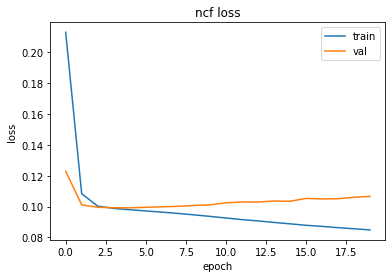

In [111]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("ncf loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="best")
plt.show()

In [112]:
def get_metrics(model, k, size=1000):  
    hit = 0
    mrr = 0
    counter = size
    for s in range(counter):
        cust_id = sample_df["Customer_num"].unique()[s]
        cust_encoder = cust2cust_encoded.get(cust_id)
        purchased = frequent_df[(frequent_df.index==cust_id) & (frequent_df["purchase"]==1)]
        candidates = frequent_df[~frequent_df["input_sequence"].isin(purchased["input_sequence"].values)]["input_sequence"][:49]
        candidates = set(candidates).intersection(set(prod2prod_encoded.keys()))
        candidates = candidates.union(set(frequent_df[frequent_df.index==cust_id]["output_sequence"].values[0]))
        candidates = [[prod2prod_encoded.get(x)] for x in list(candidates)]
        ids = np.stack([[cust_encoder]]*len(candidates))
        y_pred = model.predict([ids, np.array(list(candidates), dtype="int32")]).flatten()
        t = frequent_df.loc[(frequent_df.index==cust_id), "output_sequence"].values[0][0]
        recommend = []
        
        for i in range(k):
            p = prod_encoded2prod.get(candidates[y_pred.argsort()[-(i+1)]][0])
            recommend.append(p)
            if (p==t):
                rr = 1/(i+1)
                hit = hit + 1
        
        
    return (hit/counter)

In [113]:
recallx = get_metrics(model, 3)
print("Recall@3: ", recallx)


2/2 [==============================] - 0s 999us/step
Recall@3:  0.009
